## Random Forest - BET - 2bins - 74/26

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
import pycm
from ast import literal_eval
import sys
sys.path.append("../plotutils/")
from plotutils import *
plt.style.use("../plotutils/your.mplstyle")

In [2]:
df = pd.read_csv(f"../BET_dataset.csv", sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Precursor               74 non-null     object 
 1   Activator               74 non-null     object 
 2   Activator_carbon_ratio  74 non-null     object 
 3   Activation T (K)        74 non-null     int64  
 4   Pore volume (cm3/g)     74 non-null     float64
 5   BET (m2/g)              74 non-null     float64
 6   BET_2bins_5050          74 non-null     int64  
 7   BET_7426                74 non-null     int64  
 8   synthesis               74 non-null     object 
dtypes: float64(2), int64(3), object(4)
memory usage: 5.3+ KB


In [3]:
df["Activator_carbon_ratio"].unique()

array(['4', '1.5', '0.5', '1', '2', '3', '5', 'none', '6', '2.5', '1.25',
       '8'], dtype=object)

In [4]:
df["Activator_carbon_ratio"] = df['Activator_carbon_ratio'].replace('none', 0)

In [5]:
df["Activator_carbon_ratio"] = pd.to_numeric(df["Activator_carbon_ratio"])

In [6]:
df["Activator_carbon_ratio"].unique()

array([4.  , 1.5 , 0.5 , 1.  , 2.  , 3.  , 5.  , 0.  , 6.  , 2.5 , 1.25,
       8.  ])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Precursor               74 non-null     object 
 1   Activator-Ratio         74 non-null     object 
 2   Activator               74 non-null     object 
 3   Activator_carbon_ratio  74 non-null     float64
 4   Activation T (K)        74 non-null     int64  
 5   BET (m2/g)              74 non-null     float64
 6   Pore volume (cm3/g)     74 non-null     float64
 7   synthesis               74 non-null     object 
 8   synthesis_woNAME        74 non-null     object 
 9   2bins_BET               74 non-null     int64  
 10  3bins_BET               74 non-null     int64  
 11  4bins_BET               74 non-null     int64  
 12  5bins_BET               74 non-null     int64  
 13  10bins_BET              74 non-null     int64  
 14  bet_1800                74 non-null     int6

In [8]:
len(df["Precursor"].unique())

31

In [9]:
len(df["Activator"].unique())

10

In [10]:
encoder_precursor = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_precursor = encoder_precursor.fit_transform(df[["Precursor"]])
df = pd.concat([df, one_hot_precursor], axis=1)

In [11]:
encoder_activator = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_activator = encoder_activator.fit_transform(df[["Activator"]])
df = pd.concat([df, one_hot_activator], axis=1)

In [13]:
df.columns[15:56].to_list()

['Precursor_Acai stone',
 'Precursor_Bambo',
 'Precursor_Black locust',
 'Precursor_Catkin',
 'Precursor_Celtuce leaves',
 'Precursor_Chitosan',
 'Precursor_Chrysanthemum tea',
 'Precursor_Coconut shell',
 'Precursor_Coffee grounds',
 'Precursor_Cork',
 'Precursor_Crab shell',
 'Precursor_Empty fruit bunch',
 'Precursor_Garlic peel',
 'Precursor_Lignin Waste',
 'Precursor_Olive stone',
 'Precursor_Paulownia sawdust',
 'Precursor_Peanut shell',
 'Precursor_Pineapple',
 'Precursor_Pollen',
 'Precursor_Popcorn',
 'Precursor_Poplar Wood',
 'Precursor_Rice husk',
 'Precursor_Sugarcane bagasse',
 'Precursor_Sunflower seed shell',
 'Precursor_Tar+CaO',
 'Precursor_Tea seed shell',
 'Precursor_Urea + tobacco',
 'Precursor_Vine shoots',
 'Precursor_Walnut shell',
 'Precursor_Waste wool',
 'Precursor_Wheat',
 'Activator_CO2',
 'Activator_CO2+N2',
 'Activator_K2C2O4',
 'Activator_K2CO3',
 'Activator_KCl-ZnCl2',
 'Activator_KOH',
 'Activator_KOH+Ammonia',
 'Activator_KOH+N2',
 'Activator_NaNH2',
 

In [14]:
representation = ["Activator_carbon_ratio", "Activation T (K)"]
representation.extend(df.columns[15:56].to_list())

In [25]:
def prepare_dataset_classification(
    df,
    target = "BET_7426",
    representation=representation,
    random_state=42,
    train_size=60
):
    df_train, df_test = train_test_split(
        df,
        train_size=train_size,
        random_state=random_state,
        stratify=df[target].astype(int).values,
    )
    print(len(df_train), len(df_test))
    
    X_train, y_train = df_train[representation], df_train[target]
    X_test, y_test = df_test[representation], df_test[target]
    
    return X_train, y_train, X_test, y_test

In [26]:
def train_and_evaluate_classifier(X_train, y_train, X_test, y_test, random_state=42):
    clf = RandomForestClassifier(
        n_estimators=200, 
        random_state=random_state,
        verbose=True
    )
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    y_test = np.array(y_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa

In [27]:
def metrics_dict():
    metrics_dict = {
        "train_size": train_size,
        "y_true": y_test_all,
        "y_pred": y_pred_all,
        "accuracy": acc_scores,
        "f1_macro": f1macro_scores,
        "f1_micro": f1micro_scores,
        "f1_weighted": f1weighted_scores,
        "kappa": kappa_scores
    }
    return metrics_dict

### training size = 15

In [28]:
train_size = 15
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [29]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
15 59
random_state = 42
Accuracy: 0.7457627118644068
F1 macro: 0.42718446601941745
F1 micro: 0.7457627118644068
F1 weighted: 0.6371564916899786
Kappa: 0.0
-------------Iteration 2/10
15 59
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.7457627118644068
F1 macro: 0.48456610366919045
F1 micro: 0.7457627118644068
F1 weighted: 0.6649161426611255
Kappa: 0.06150583244962882
-------------Iteration 3/10
15 59
random_state = 44
Accuracy: 0.711864406779661
F1 macro: 0.46677299308878256
F1 micro: 0.711864406779661
F1 weighted: 0.6444642680146695
Kappa: -0.0019980019980021524
-------------Iteration 4/10
15 59
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7288135593220338
F1 macro: 0.5815602836879432
F1 micro: 0.7288135593220338
F1 weighted: 0.703570140641904
Kappa: 0.17626527050610818
-------------Iteration 5/10
15 59
random_state = 46
Accuracy: 0.7288135593220338
F1 macro: 0.4215686274509804
F1 micro: 0.7288135593220338
F1 weighted: 0.628780325689598
Kappa: -0.03282275711159732
-------------Iteration 6/10
15 59
random_state = 47


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7288135593220338
F1 macro: 0.5183673469387755
F1 micro: 0.7288135593220338
F1 weighted: 0.6748529920442753
Kappa: 0.08349514563106808
-------------Iteration 7/10
15 59
random_state = 48
Accuracy: 0.7288135593220338
F1 macro: 0.4755555555555555
F1 micro: 0.7288135593220338
F1 weighted: 0.6546892655367231
Kappa: 0.028806584362139898
-------------Iteration 8/10
15 59
random_state = 49


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.8135593220338984
F1 macro: 0.6813942071674031
F1 micro: 0.8135593220338984
F1 weighted: 0.7822570579865705
Kappa: 0.3871576959395656
-------------Iteration 9/10
15 59
random_state = 50
Accuracy: 0.7627118644067796
F1 macro: 0.5785714285714285
F1 micro: 0.7627118644067796
F1 weighted: 0.715496368038741
Kappa: 0.19805825242718456
-------------Iteration 10/10
15 59
random_state = 51


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7627118644067796
F1 macro: 0.5785714285714285
F1 micro: 0.7627118644067796
F1 weighted: 0.715496368038741
Kappa: 0.19805825242718456


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [30]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 15
mean accuracy: 0.7457627118644068 +/- 0.02732968728236799
mean F1 macro: 0.5214112440720904 +/- 0.07813397145180066
mean F1 micro: 0.7457627118644068 +/- 0.02732968728236799
mean F1 weighted: 0.6821679420342326 +/- 0.044834695504584
mean Kappa: 0.10985262746332802 +/- 0.12304642363074075


In [31]:
compiled_res_15 = pd.DataFrame(metrics_dict())
compiled_res_15.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,15,"[0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.745763,0.427184,0.745763,0.637156,0.000000
1,15,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.745763,0.484566,0.745763,0.664916,0.061506
2,15,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.711864,0.466773,0.711864,0.644464,-0.001998


### training size = 25

In [32]:
train_size = 25
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [33]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
25 49
random_state = 42
Accuracy: 0.7551020408163265
F1 macro: 0.6483253588516746
F1 micro: 0.7551020408163265
F1 weighted: 0.7392832731178596
Kappa: 0.3033175355450236
-------------Iteration 2/10
25 49
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.7346938775510204
F1 macro: 0.4883534136546185
F1 micro: 0.7346938775510204
F1 weighted: 0.6549954921727728
Kappa: 0.06734992679355778
-------------Iteration 3/10
25 49
random_state = 44
Accuracy: 0.7551020408163265
F1 macro: 0.5916666666666667
F1 micro: 0.7551020408163265
F1 weighted: 0.7129251700680271
Kappa: 0.21808510638297873
-------------Iteration 4/10
25 49
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7551020408163265
F1 macro: 0.5
F1 micro: 0.7551020408163265
F1 weighted: 0.6676384839650145
Kappa: 0.10909090909090913
-------------Iteration 5/10
25 49
random_state = 46
Accuracy: 0.7551020408163265
F1 macro: 0.5916666666666667
F1 micro: 0.7551020408163265
F1 weighted: 0.7129251700680271
Kappa: 0.21808510638297873
-------------Iteration 6/10
25 49
random_state = 47


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.7346938775510204
F1 macro: 0.4883534136546185
F1 micro: 0.7346938775510204
F1 weighted: 0.6549954921727728
Kappa: 0.06734992679355778
-------------Iteration 7/10
25 49
random_state = 48
Accuracy: 0.7551020408163265
F1 macro: 0.5518292682926829
F1 micro: 0.7551020408163265
F1 weighted: 0.693504230960677
Kappa: 0.16713881019830024
-------------Iteration 8/10
25 49
random_state = 49


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.7551020408163265
F1 macro: 0.5518292682926829
F1 micro: 0.7551020408163265
F1 weighted: 0.693504230960677
Kappa: 0.16713881019830024
-------------Iteration 9/10
25 49
random_state = 50
Accuracy: 0.7346938775510204
F1 macro: 0.4883534136546185
F1 micro: 0.7346938775510204
F1 weighted: 0.6549954921727728
Kappa: 0.06734992679355778
-------------Iteration 10/10
25 49
random_state = 51
Accuracy: 0.7755102040816326
F1 macro: 0.6085693536673928
F1 micro: 0.7755102040816326
F1 weighted: 0.7285580899026277
Kappa: 0.2606310013717421


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [34]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 25
mean accuracy: 0.7510204081632652 +/- 0.012244897959183642
mean F1 macro: 0.5508946823401623 +/- 0.055199692307783696
mean F1 micro: 0.7510204081632652 +/- 0.012244897959183642
mean F1 weighted: 0.6913325125561228 +/- 0.03024811006928538
mean Kappa: 0.1645537059550906 +/- 0.0810263415034459


In [35]:
compiled_res_25 = pd.DataFrame(metrics_dict())
compiled_res_25.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,25,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...",0.755102,0.648325,0.755102,0.739283,0.303318
1,25,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.734694,0.488353,0.734694,0.654995,0.067350
2,25,"[0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0.755102,0.591667,0.755102,0.712925,0.218085


### training size = 35

In [36]:
train_size = 35
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [37]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
35 39
random_state = 42
Accuracy: 0.717948717948718
F1 macro: 0.546031746031746
F1 micro: 0.717948717948718
F1 weighted: 0.6821326821326822
Kappa: 0.11546391752577312
-------------Iteration 2/10
35 39
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7692307692307693
F1 macro: 0.6285714285714286
F1 micro: 0.7692307692307693
F1 weighted: 0.7399267399267399
Kappa: 0.27628865979381434
-------------Iteration 3/10
35 39
random_state = 44
Accuracy: 0.7692307692307693
F1 macro: 0.6615236258437801
F1 micro: 0.7692307692307693
F1 weighted: 0.7545434314961798
Kappa: 0.3288718929254302
-------------Iteration 4/10
35 39
random_state = 45


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.7692307692307693
F1 macro: 0.6285714285714286
F1 micro: 0.7692307692307693
F1 weighted: 0.7399267399267399
Kappa: 0.27628865979381434
-------------Iteration 5/10
35 39
random_state = 46
Accuracy: 0.7435897435897436
F1 macro: 0.5075757575757576
F1 micro: 0.7435897435897436
F1 weighted: 0.6736596736596737
Kappa: 0.08878504672897192
-------------Iteration 6/10
35 39
random_state = 47


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7435897435897436
F1 macro: 0.5075757575757576
F1 micro: 0.7435897435897436
F1 weighted: 0.6736596736596737
Kappa: 0.08878504672897192
-------------Iteration 7/10
35 39
random_state = 48
Accuracy: 0.7948717948717948
F1 macro: 0.6517857142857143
F1 micro: 0.7948717948717948
F1 weighted: 0.7605311355311355
Kappa: 0.33047210300429186
-------------Iteration 8/10
35 39
random_state = 49


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.7692307692307693
F1 macro: 0.5846153846153846
F1 micro: 0.7692307692307693
F1 weighted: 0.7195266272189349
Kappa: 0.21476510067114085
-------------Iteration 9/10
35 39
random_state = 50
Accuracy: 0.7948717948717948
F1 macro: 0.6517857142857143
F1 micro: 0.7948717948717948
F1 weighted: 0.7605311355311355
Kappa: 0.33047210300429186
-------------Iteration 10/10
35 39
random_state = 51


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7948717948717948
F1 macro: 0.6060606060606061
F1 micro: 0.7948717948717948
F1 weighted: 0.7389277389277389
Kappa: 0.2710280373831776


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [39]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 35
mean accuracy: 0.7666666666666666 +/- 0.024189695210401527
mean F1 macro: 0.5974097163417318 +/- 0.05566390685190622
mean F1 micro: 0.7666666666666666 +/- 0.024189695210401527
mean F1 weighted: 0.7243365578010634 +/- 0.033424775216657605
mean Kappa: 0.23212205675596778 +/- 0.09440467638280604


In [40]:
compiled_res_35 = pd.DataFrame(metrics_dict())
compiled_res_35.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,35,"[0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.717949,0.546032,0.717949,0.682133,0.115464
1,35,"[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, ...","[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, ...",0.769231,0.628571,0.769231,0.739927,0.276289
2,35,"[0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, ...","[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.769231,0.661524,0.769231,0.754543,0.328872


### training size = 45

In [41]:
train_size = 45
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [42]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
45 29
random_state = 42
Accuracy: 0.6551724137931034
F1 macro: 0.5292207792207793
F1 micro: 0.6551724137931034
F1 weighted: 0.6551724137931034
Kappa: 0.05844155844155852
-------------Iteration 2/10
45 29
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.7586206896551724
F1 macro: 0.5396825396825397
F1 micro: 0.7586206896551724
F1 weighted: 0.7038861521620142
Kappa: 0.128755364806867
-------------Iteration 3/10
45 29
random_state = 44
Accuracy: 0.8275862068965517
F1 macro: 0.7195357833655706
F1 micro: 0.8275862068965517
F1 weighted: 0.8095778029747214
Kappa: 0.4486692015209125
-------------Iteration 4/10
45 29
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.7586206896551724
F1 macro: 0.5396825396825397
F1 micro: 0.7586206896551724
F1 weighted: 0.7038861521620142
Kappa: 0.128755364806867
-------------Iteration 5/10
45 29
random_state = 46
Accuracy: 0.8275862068965517
F1 macro: 0.6712018140589568
F1 micro: 0.8275862068965517
F1 weighted: 0.788490108687153
Kappa: 0.3776824034334765
-------------Iteration 6/10
45 29
random_state = 47


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7241379310344828
F1 macro: 0.42
F1 micro: 0.7241379310344828
F1 weighted: 0.6372413793103449
Kappa: -0.06422018348623837
-------------Iteration 7/10
45 29
random_state = 48
Accuracy: 0.8275862068965517
F1 macro: 0.7195357833655706
F1 micro: 0.8275862068965517
F1 weighted: 0.8095778029747214
Kappa: 0.4486692015209125
-------------Iteration 8/10
45 29
random_state = 49


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7586206896551724
F1 macro: 0.6073500967117988
F1 micro: 0.7586206896551724
F1 weighted: 0.7334089241646102
Kappa: 0.22813688212927752
-------------Iteration 9/10
45 29
random_state = 50
Accuracy: 0.8275862068965517
F1 macro: 0.6712018140589568
F1 micro: 0.8275862068965517
F1 weighted: 0.788490108687153
Kappa: 0.3776824034334765
-------------Iteration 10/10
45 29
random_state = 51
Accuracy: 0.7586206896551724
F1 macro: 0.5396825396825397
F1 micro: 0.7586206896551724
F1 weighted: 0.7038861521620142
Kappa: 0.128755364806867


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [43]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 45
mean accuracy: 0.7724137931034483 +/- 0.053863790868321756
mean F1 macro: 0.5957093689829251 +/- 0.09322618655088205
mean F1 micro: 0.7724137931034483 +/- 0.053863790868321756
mean F1 weighted: 0.733361699707785 +/- 0.05971195702056516
mean Kappa: 0.22613275614139766 +/- 0.16907270126183974


In [44]:
compiled_res_45 = pd.DataFrame(metrics_dict())
compiled_res_45.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,45,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",0.655172,0.529221,0.655172,0.655172,0.058442
1,45,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.758621,0.539683,0.758621,0.703886,0.128755
2,45,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",0.827586,0.719536,0.827586,0.809578,0.448669


### training size = 55

In [45]:
train_size = 55
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [46]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
55 19
random_state = 42
Accuracy: 0.7894736842105263
F1 macro: 0.6833333333333333
F1 micro: 0.7894736842105263
F1 weighted: 0.7701754385964912
Kappa: 0.3770491803278688
-------------Iteration 2/10
55 19
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7894736842105263
F1 macro: 0.6041666666666666
F1 micro: 0.7894736842105263
F1 weighted: 0.7324561403508771
Kappa: 0.26923076923076916
-------------Iteration 3/10
55 19
random_state = 44
Accuracy: 0.8947368421052632
F1 macro: 0.8416666666666667
F1 micro: 0.8947368421052632
F1 weighted: 0.8850877192982456
Kappa: 0.6885245901639344
-------------Iteration 4/10
55 19
random_state = 45


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.7894736842105263
F1 macro: 0.6041666666666666
F1 micro: 0.7894736842105263
F1 weighted: 0.7324561403508771
Kappa: 0.26923076923076916
-------------Iteration 5/10
55 19
random_state = 46
Accuracy: 0.7894736842105263
F1 macro: 0.6833333333333333
F1 micro: 0.7894736842105263
F1 weighted: 0.7701754385964912
Kappa: 0.3770491803278688
-------------Iteration 6/10
55 19
random_state = 47


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7894736842105263
F1 macro: 0.6041666666666666
F1 micro: 0.7894736842105263
F1 weighted: 0.7324561403508771
Kappa: 0.26923076923076916
-------------Iteration 7/10
55 19
random_state = 48
Accuracy: 0.8421052631578947
F1 macro: 0.7373271889400921
F1 micro: 0.8421052631578947
F1 weighted: 0.815910744603444
Kappa: 0.49557522123893805
-------------Iteration 8/10
55 19
random_state = 49


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.7368421052631579
F1 macro: 0.5622119815668203
F1 micro: 0.7368421052631579
F1 weighted: 0.6931845743390735
Kappa: 0.15929203539823011
-------------Iteration 9/10
55 19
random_state = 50
Accuracy: 0.8947368421052632
F1 macro: 0.8416666666666667
F1 micro: 0.8947368421052632
F1 weighted: 0.8850877192982456
Kappa: 0.6885245901639344
-------------Iteration 10/10
55 19
random_state = 51


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7894736842105263
F1 macro: 0.6041666666666666
F1 micro: 0.7894736842105263
F1 weighted: 0.7324561403508771
Kappa: 0.26923076923076916


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [47]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 55
mean accuracy: 0.8105263157894737 +/- 0.048237638894272
mean F1 macro: 0.676620583717358 +/- 0.09609549498092848
mean F1 micro: 0.8105263157894737 +/- 0.048237638894272
mean F1 weighted: 0.77494461961355 +/- 0.06316051525410707
mean Kappa: 0.38629378745438514 +/- 0.1735353191381589


In [48]:
compiled_res_55 = pd.DataFrame(metrics_dict())
compiled_res_55.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,55,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.789474,0.683333,0.789474,0.770175,0.377049
1,55,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.789474,0.604167,0.789474,0.732456,0.269231
2,55,"[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.894737,0.841667,0.894737,0.885088,0.688525


### training size = 65

In [49]:
train_size = 65
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [50]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
65 9
random_state = 42
Accuracy: 0.8888888888888888
F1 macro: 0.8615384615384616
F1 micro: 0.8888888888888888
F1 weighted: 0.8957264957264957
Kappa: 0.7272727272727273
-------------Iteration 2/10
65 9
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.7777777777777778
F1 macro: 0.4375
F1 micro: 0.7777777777777778
F1 weighted: 0.6805555555555556
Kappa: 0.0
-------------Iteration 3/10
65 9
random_state = 44
Accuracy: 0.7777777777777778
F1 macro: 0.6785714285714286
F1 micro: 0.7777777777777778
F1 weighted: 0.7777777777777778
Kappa: 0.3571428571428572
-------------Iteration 4/10
65 9
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.8888888888888888
F1 macro: 0.8
F1 micro: 0.8888888888888888
F1 weighted: 0.874074074074074
Kappa: 0.6086956521739131
-------------Iteration 5/10
65 9
random_state = 46
Accuracy: 0.7777777777777778
F1 macro: 0.6785714285714286
F1 micro: 0.7777777777777778
F1 weighted: 0.7777777777777778
Kappa: 0.3571428571428572
-------------Iteration 6/10
65 9
random_state = 47


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.7777777777777778
F1 macro: 0.4375
F1 micro: 0.7777777777777778
F1 weighted: 0.6805555555555556
Kappa: 0.0
-------------Iteration 7/10
65 9
random_state = 48
Accuracy: 0.7777777777777778
F1 macro: 0.4375
F1 micro: 0.7777777777777778
F1 weighted: 0.6805555555555556
Kappa: 0.0
-------------Iteration 8/10
65 9
random_state = 49


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7777777777777778
F1 macro: 0.4375
F1 micro: 0.7777777777777778
F1 weighted: 0.6805555555555556
Kappa: 0.0
-------------Iteration 9/10
65 9
random_state = 50
Accuracy: 0.8888888888888888
F1 macro: 0.8
F1 micro: 0.8888888888888888
F1 weighted: 0.874074074074074
Kappa: 0.6086956521739131
-------------Iteration 10/10
65 9
random_state = 51
Accuracy: 0.7777777777777778
F1 macro: 0.4375
F1 micro: 0.7777777777777778
F1 weighted: 0.6805555555555556
Kappa: 0.0


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [51]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 65
mean accuracy: 0.8111111111111112 +/- 0.05091750772173153
mean F1 macro: 0.6006181318681318 +/- 0.171107198787588
mean F1 micro: 0.8111111111111112 +/- 0.05091750772173153
mean F1 weighted: 0.7602207977207978 +/- 0.0875420929658631
mean Kappa: 0.26589497459062683 +/- 0.2860152232795289


In [52]:
compiled_res_65 = pd.DataFrame(metrics_dict())
compiled_res_65.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,65,"[0, 0, 0, 1, 1, 0, 0, 0, 0]","[0, 0, 0, 1, 1, 1, 0, 0, 0]",0.888889,0.861538,0.888889,0.895726,0.727273
1,65,"[0, 0, 0, 0, 1, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.777778,0.437500,0.777778,0.680556,0.000000
2,65,"[1, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 1, 0, 0, 0]",0.777778,0.678571,0.777778,0.777778,0.357143


In [53]:
compiled_res = pd.concat([
    compiled_res_15, 
    compiled_res_25,
    compiled_res_35,
    compiled_res_45,
    compiled_res_55,
    compiled_res_65,
], ignore_index=True)
print(len(compiled_res))
compiled_res.head()

60


,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,15,"[0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.745763,0.427184,0.745763,0.637156,0.000000
1,15,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.745763,0.484566,0.745763,0.664916,0.061506
2,15,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.711864,0.466773,0.711864,0.644464,-0.001998
3,15,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0.728814,0.581560,0.728814,0.703570,0.176265
4,15,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.728814,0.421569,0.728814,0.628780,-0.032823


In [54]:
compiled_res["y_true"] = compiled_res["y_true"].apply(lambda arr: list(arr))
compiled_res["y_pred"] = compiled_res["y_pred"].apply(lambda arr: list(arr))

In [55]:
compiled_res.to_csv("RF_results_BET_2bins_7426.csv", sep=",", index=False)

In [56]:
df = pd.read_csv("RF_results_BET_2bins_7426.csv", sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   train_size   60 non-null     int64  
 1   y_true       60 non-null     object 
 2   y_pred       60 non-null     object 
 3   accuracy     60 non-null     float64
 4   f1_macro     60 non-null     float64
 5   f1_micro     60 non-null     float64
 6   f1_weighted  60 non-null     float64
 7   kappa        60 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.9+ KB


In [57]:
df.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,15,"[0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.745763,0.427184,0.745763,0.637156,0.000000
1,15,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.745763,0.484566,0.745763,0.664916,0.061506
2,15,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.711864,0.466773,0.711864,0.644464,-0.001998


In [58]:
grouped_res = df.select_dtypes(include = ["int", "float"]).groupby(['train_size']).agg(['mean', 'sem'])
grouped_res

accuracy            f1_macro            f1_micro            \
                mean       sem      mean       sem      mean       sem   
train_size                                                               
15          0.745763  0.009110  0.521411  0.026045  0.745763  0.009110   
25          0.751020  0.004082  0.550895  0.018400  0.751020  0.004082   
35          0.766667  0.008063  0.597410  0.018555  0.766667  0.008063   
45          0.772414  0.017955  0.595709  0.031075  0.772414  0.017955   
55          0.810526  0.016079  0.676621  0.032032  0.810526  0.016079   
65          0.811111  0.016973  0.600618  0.057036  0.811111  0.016973   

           f1_weighted               kappa            
                  mean       sem      mean       sem  
train_size                                            
15            0.682168  0.014945  0.109853  0.041015  
25            0.691333  0.010083  0.164554  0.027009  
35            0.724337  0.011142  0.232122  0.031468  
45            0.733362  0.019904  0.226133  0.056358  
55            0.774945  0.021054  0.386294  0.057845  
65            0.760221  0.029181  0.265895  0.095338

In [59]:
conf_mats = []
for i in np.arange(len(df)):
    confusion_matrix = {
        'all_y_true': literal_eval(df["y_true"][i]),
        'all_y_pred': literal_eval(df["y_pred"][i])
    }
    conf_mats.append(confusion_matrix)

[[0.95714286 0.04285714]
 [0.7        0.3       ]]
accuracy: 0.8111111111111111


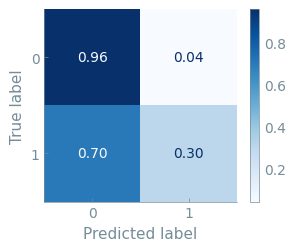

In [60]:
index_maxsize = compiled_res[compiled_res["train_size"]==max(compiled_res["train_size"])].index
conf_mats_max = [conf_mats[i] for i in index_maxsize]

actual_all, predicted_all = [], []
for index, _ in enumerate(conf_mats_max):
    preds = conf_mats_max[index]
    actual = preds["all_y_true"]
    predicted = preds["all_y_pred"]
    
    for true, pred in zip(actual, predicted):
        actual_all.append(true)
        predicted_all.append(pred)

confusion_matrix = metrics.confusion_matrix(actual_all, predicted_all)
confusion_matrix_norm = confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:, np.newaxis]
print(confusion_matrix_norm)

cm = pycm.ConfusionMatrix(list(actual_all), list(predicted_all))
acc = cm.Overall_ACC

print(f'accuracy: {acc}')

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix_norm, display_labels = [0, 1])
cm_display.plot(cmap=plt.cm.Blues, include_values=True, values_format=".2f")
#plt.savefig('classif_BET_confusionMatrix_74_26_size65_RF.pdf', bbox_inches='tight')